# Movie Classification Based On Plot Summaries

In [238]:
#Importing python libraries
import re
import csv
import fileinput
import numpy as np
import pandas as pd
from IPython.display import Image

#Importing ML classifiers
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

#Importing libraries for ML model evaluation and improvements
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit, GridSearchCV

# Data Gathering

In order to create the dataset for this project we need to download genres.list and plot.list files from IMDB Database (ftp://ftp.fu-berlin.de/pub/misc/movies/database) and then parse files in order to associate the Title, Plot, and Genre.

The data in genre.list conatins the 'Title' and 'Genre' of the movies and data in plot.list contains 'Title' and 'Plot' of the movies.
* genre.list -- It contains the 'Title' and 'Genre' of the movies
* plot.list  -- It contains the 'Title' and 'Plot' of the movies

From the above two files data is extracted and stored in csv format.
* moviesGenre.csv -- It contains the 'Title' and 'Genre' of the movies in csv format.
* moviesPlot.csv  -- It contains the 'Title' and 'Plot' of the movies in csv format.

As a part of data gathering, I am also cleaing the data from unwanted spaces, comments, tabs etc.

For this project, Instead of using the plot.list directly from the IMDB database, kindly use the plot.list file provided with this project as one manual step for data cleaning on plot.list was performed. 

In [212]:
#Initilization
mName = ""
moviePlot = ""
movideDict = {}

#File path
plotFile="data/plot.list"
file = fileinput.input([plotFile],openhook=fileinput.hook_encoded('latin-1'))

#Extracting movies and its plot from the raw file. 
for line in file:
    #If line contains "MV:", then extract the movie name from it. 
    if line.find("MV:") == 0:
        if mName != "":
            movideDict[mName] = moviePlot
            mName = ""
            moviePlot = ""
        mName = str(re.findall('"([^"]*)"',line)).strip('[]').strip("'").strip('#')
    #If line contains "PL:", then extract the plot of the movie.    
    elif line.find("PL:") == 0:
        moviePlot += line.split('PL:',1)[1].strip('\n')
file.close()

#Writing movies and its plot in csv format. 
#Format of csv file: <movie name>,<plot>
plotCsvFile = "data/moviesPlot.csv"
with open(plotCsvFile, "w") as csv_file:
        writer = csv.writer(csv_file)
        for key,value in movideDict.items():
            writer.writerow([key,value])

In [213]:
#File path
genreFile="data/genres.list"
file = fileinput.input([genreFile],openhook=fileinput.hook_encoded('latin-1'))

movieGenreDict = {}
#Extracting movies and its plot from the raw file. 
for line in file:
    mName = str(re.findall('"([^"]*)"',line)).strip('[]').strip("'").strip('#')
    lineList = line.split('\t')
    movieGenreDict[mName] = lineList[-1].strip('\n').strip('\t')
file.close()

#Writing movies genre and its plot in csv format. 
#Format of csv file: <movie name>,<genre>
genreCsvFile = "data/moviesGenre.csv"
with open(genreCsvFile, "w") as csv_file:
        writer = csv.writer(csv_file)
        for key,value in movieGenreDict.items():
            writer.writerow([key,value])

Loading data into dataframes:
* moviesPlot.csv  ---------> moviePlotsDF
* moviesGenre.csv ---------> movieGenreDF
* movieDFAnother  ---------> movieDFAnother

In [222]:
#Path of csv files.
genreCsvFile = "data/moviesGenre.csv"
plotCsvFile = "data/moviesPlot.csv"

#Read the plot file into dataframes
moviePlotsDF = pd.read_csv(plotCsvFile)
moviePlotsDF.columns=["Title","Plot"]
display(moviePlotsDF.head())
print ("Shape:",moviePlotsDF.shape,"\n")

#Read the genre file into dataframes
movieGenreDF = pd.read_csv(genreCsvFile)
movieGenreDF.columns=["Title","Genre"]
display (movieGenreDF.head())
print ("Shape:",movieGenreDF.shape,"\n")

#Read another movies database
movieDFAnother = pd.read_csv('data/trainingSet.csv')
movieDFAnother = movieDFAnother[['Title', 'Plot','Genre1']]
movieDFAnother.rename(columns={'Genre1':'Genre'},inplace=True)
display(movieDFAnother.head())
print ("Shape:",movieDFAnother.shape,"\n")

,Title,Plot
0,BlackLove,Follows five dynamic black women in New York ...
1,Cake,"Cake, Amy and Benjamin discover they all have..."
2,CandidlyNicole,"When you're married to a sports nut, sometime..."
3,DaddyLeaks,The life of four close friends in their late ...
4,DearGeorgette,My conversations with my guy friends have led...


Shape: (35702, 2) 



,Title,Genre
0,1 Single,Reality-TV
1,15SecondScare,Thriller
2,1MinuteNightmare,Horror
3,2G1S,Crime
4,2WheelzNHeelz,Reality-TV


Shape: (134050, 2) 



,Title,Plot,Genre
0,Toy Story,A little boy named Andy loves to be in his roo...,Animation
1,Jumanji,After being trapped in a jungle board game for...,Action
2,Grumpier Old Men,Things don't seem to change much in Wabasha Co...,Comedy
3,Waiting to Exhale,This story based on the best selling novel by ...,Comedy
4,Father of the Bride Part II,"In this sequel to ""Father of the Bride"", Georg...",Comedy


Shape: (4456, 3) 



# Data Cleaning

As a part of this step data in moviesDF dataframe is cleaned.

There is a difference in the shape of moviePlotsDF and movieGenreDF data. It means movieGenreDF dataframe contains more movies Title and Genre but for many movies their respective plots are missing in moviePlotsDF. So while merging we will only take movies which has plot summary.

In [223]:
#Merge three dataframes in one based on Title of the movies
moviesDF = pd.merge(moviePlotsDF,movieGenreDF,on='Title')
moviesDF = pd.concat([moviesDF,movieDFAnother], axis=0)
display(moviesDF.head())
print ("Shape:", moviesDF.shape)

,Title,Plot,Genre
0,BlackLove,Follows five dynamic black women in New York ...,Reality-TV
1,Cake,"Cake, Amy and Benjamin discover they all have...",Family
2,CandidlyNicole,"When you're married to a sports nut, sometime...",Reality-TV
3,DaddyLeaks,The life of four close friends in their late ...,Comedy
4,DearGeorgette,My conversations with my guy friends have led...,Romance


Shape: (37994, 3)


Checking for any null value in moviesDF so that it can be removed.

In [230]:
#Checking for the null data in moviesDF dataframe
print (moviesDF.isnull().any(),"\n")

# Displaying total movies count based on Genres
display('Movies count based on Genre:',moviesDF.Genre.value_counts())

Title    False
Plot     False
Genre    False
dtype: bool 



'Movies count based on Genre:'

Comedy         6603
Drama          5354
Documentary    3886
Reality-TV     3552
Romance        1814
Sci-Fi         1737
Family         1673
Thriller       1501
Talk-Show      1465
Action         1010
Animation       934
Fantasy         876
Crime           852
Mystery         756
Sport           684
Music           672
History         630
Short           609
Adventure       587
Game-Show       545
Horror          543
News            496
War             427
Biography       331
Western         223
Musical         209
Adult            23
Reality-tv        1
Sci-fi            1
Name: Genre, dtype: int64

For this project I am only considering data which are movies, so the below genres which I think are not movies are removed from moviesDF dataframe:
* Reality-TV
* Reality-tv
* Talk-Show
* News

In [231]:
#For this project, I am just considering prediction of movies based on movies plots. 
#Hence I will remove all the data which are not movies (Ex: Reality-TV, Talk-Show,News,Game-Show)

#Removing genres which are not part of movies.
moviesDF = moviesDF.loc[moviesDF.Genre != 'Reality-TV']
moviesDF = moviesDF.loc[moviesDF.Genre != 'Reality-tv']
moviesDF = moviesDF.loc[moviesDF.Genre != 'Talk-Show']
moviesDF = moviesDF.loc[moviesDF.Genre != 'Game-Show']
moviesDF = moviesDF.loc[(moviesDF.Genre != 'News')]

#Renaming Sci-fi with Sci-Fi as both are same genre.
moviesDF['Genre'] = moviesDF['Genre'].replace('Sci-fi','Sci-Fi')

print ("Shape:", moviesDF.shape,"\n")
print (moviesDF.head())

Shape: (31935, 3) 

           Title                                               Plot    Genre
1           Cake   Cake, Amy and Benjamin discover they all have...   Family
3     DaddyLeaks   The life of four close friends in their late ...   Comedy
4  DearGeorgette   My conversations with my guy friends have led...  Romance
5         Elmira   #Elmira follows the story of a bunch of stran...   Comedy
6           Fuga   Months after an apocalyptic event, a group of...   Horror


# Final Numbers For Movie Dataset

Here are some numbers of my movie dataset:
* Total Movies (rows)  : 31935
* Features    (columns): 3
* Total Genres         : 23

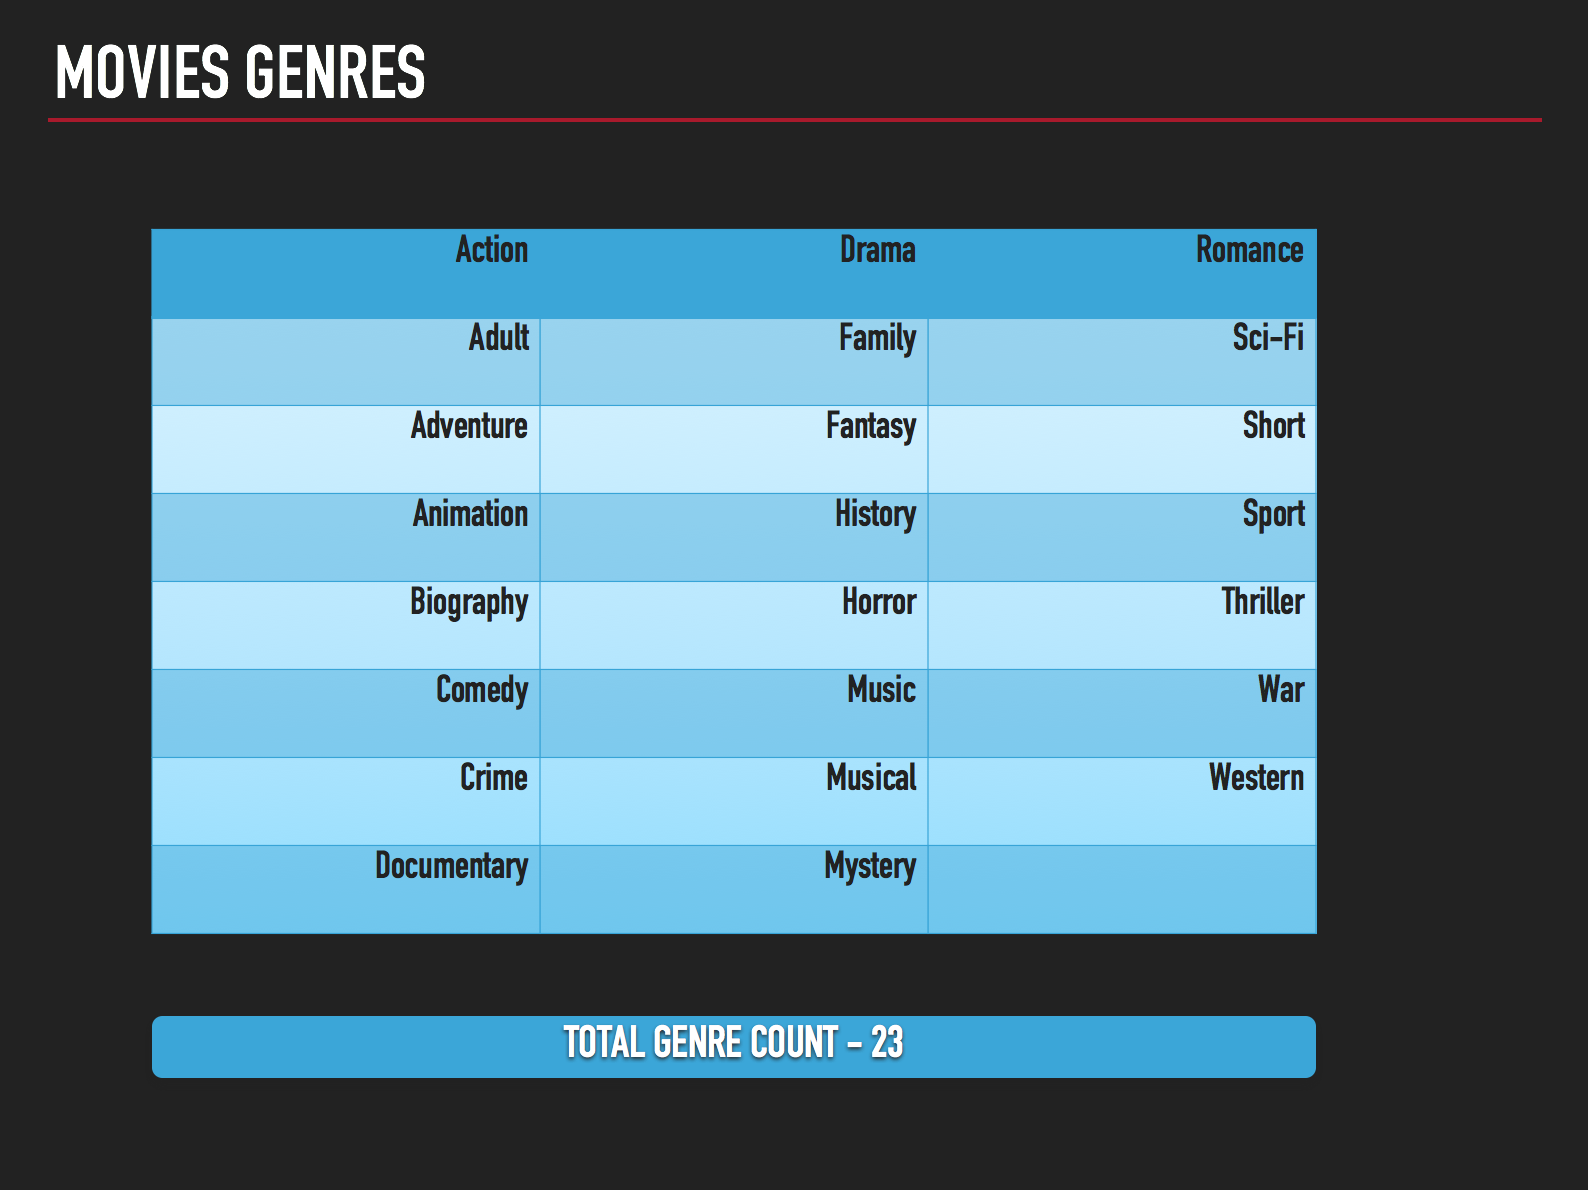

In [299]:
Image(filename='images/movie_genre.png')

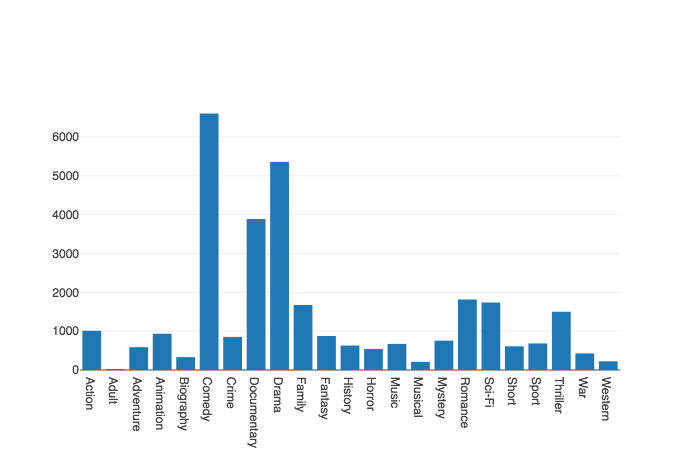

In [244]:
Image(filename='images/movies_genre_histogram.png')

In [298]:
#import plotly
#plotly.offline.init_notebook_mode(connected=True)
#import plotly.graph_objs as go

#Create a pivot tables for medals
#moviesGenrePivot = moviesDF.pivot_table(index=['Genre'],values='Title',aggfunc='count')

#Prepare the data from bar chart.
#moviesGenreG = [go.Bar(x=moviesGenrePivot.index,y=moviesGenrePivot['Title'],)]

#Plot the graph.
#plotly.offline.iplot(moviesGenreG, filename='bar-chart')

# Data Split 

I have used 90-10 train-test split ratio for test and train sets respectively

In [279]:
#Split the data
X = moviesDF['Plot']
y = moviesDF['Genre']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.1)
print("X Training Shape  :", X_train.shape)
print("y Training Shape:", y_train.shape,"\n")

print("X_Testing Shape :", X_test.shape)
print("y Testing Shape :", y_test.shape)

X Training Shape  : (28741,)
y Training Shape: (28741,) 

X_Testing Shape : (3194,)
y Testing Shape : (3194,)


# TF-IDF Vectorization

This is an acronym than stands for “Term Frequency – Inverse Document” Frequency which are the components of the resulting scores assigned to each word. 
* Term Frequency: This is based on bag-of-words representations. This summarizes how often a given word appears within                   a document. In bag-of-words representations order of words does not matters.

                  Bag-of-words representations consists of three steps:
                   * Tokenization: Split each document into the words that appear in it (called tokens).
                                   For example by spliting them on whitespaces and punctuations
                   * Vocabulary building: Collect a vocabulary of all words that appears in any of the documents,
                                          and number them
                   * Encoding           : For each document, count how often each of the word in the vocabulary
                                          appears in this dcouments.

* Inverse Document Frequency: This downscales words that appear a lot across documents.

In [280]:
#The TfidfVectorizer will tokenize documents, learn the vocabulary and
#inverse document frequency weightings,and allow to encode new documents. 

#stop_words='english' means all the stop words like (a, an, is, the) are 
#removed as they hold no meaning in this proces.
vecModel = TfidfVectorizer(stop_words='english')
                           
#Combine fit and transform into a single step this is faster.
X_train_dtm = vecModel.fit_transform(X_train)

#Transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vecModel.transform(X_test)

#The below commented command will display all the words that appear in the documents and number assigned to them.
#print (vecModel.vocabulary_)

#This command displays the assigned number to word along with Inverse Document Frequency
print (X_test_dtm[0])

  (0, 80762)	0.221577564888
  (0, 79326)	0.234502389097
  (0, 79230)	0.274021181176
  (0, 75239)	0.0838291829618
  (0, 67447)	0.184538745391
  (0, 61046)	0.154288675589
  (0, 56006)	0.18389703204
  (0, 54496)	0.211081221676
  (0, 53592)	0.145145130907
  (0, 51744)	0.0744052350473
  (0, 44103)	0.171629387862
  (0, 42527)	0.178983340742
  (0, 40729)	0.207051238645
  (0, 35711)	0.201643025446
  (0, 31000)	0.241573286394
  (0, 30987)	0.215821596058
  (0, 30577)	0.228906365469
  (0, 29538)	0.234502389097
  (0, 23028)	0.162792072185
  (0, 15693)	0.260254079434
  (0, 9242)	0.157661908338
  (0, 6749)	0.236659595097
  (0, 5261)	0.274021181176
  (0, 2538)	0.145754211914
  (0, 1777)	0.148938172663


Let decode above output:
(0, 82480)	0.412519622729

(0, 82480)       ——> It represents the word "wright". It has been assigned the number 82480.
                     You can search it with command "print (vecModel.vocabulary_)"

0.412519622729   ——> It represents the downscale frequency of word "wright" based on how 
                     often it appears in the documents.

# Machine Learning Methods

For this project, I experiment with 3 machine learning methods:
* MultinomialNB -- The first method is to use Naive Bayes, a simple approach that was shown very effective for many text classification tasks. Naive Bayes makes two key assumptions. The first is the bag-of-words assumption, meaning that the order of words does not matter. We already have completed it with TF-IDF Vectorization. The second is the conditional independence assumption. For the document d = W1 W2...Wn and given the class c, the probabilites P(Wi|c) are independent.

* The other two most common linear classification algorithms, I used to solve text classification problem are LogisticRegression and LinearSVC

In [281]:
#Supervised Classifier: Naive Bayes (MultinomialNB)
nb = MultinomialNB()
%time nb.fit(X_train_dtm, y_train)

CPU times: user 154 ms, sys: 28.9 ms, total: 183 ms
Wall time: 181 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [282]:
#Make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)
print("Accuracy Score:", accuracy_score(y_test, y_pred_class,"\n"))
print(classification_report(y_test, y_pred_class),"\n")

Accuracy Score: 0.324045084534
             precision    recall  f1-score   support

     Action       0.00      0.00      0.00       100
      Adult       0.00      0.00      0.00         1
  Adventure       0.00      0.00      0.00        60
  Animation       0.00      0.00      0.00        94
  Biography       0.00      0.00      0.00        38
     Comedy       0.29      0.94      0.45       659
      Crime       0.00      0.00      0.00       108
Documentary       0.65      0.43      0.52       391
      Drama       0.30      0.48      0.37       505
     Family       0.00      0.00      0.00       164
    Fantasy       0.00      0.00      0.00       101
    History       0.00      0.00      0.00        53
     Horror       0.00      0.00      0.00        46
      Music       0.00      0.00      0.00        55
    Musical       0.00      0.00      0.00        20
    Mystery       0.00      0.00      0.00        75
    Romance       0.00      0.00      0.00       193
     Sci-Fi   

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



In [283]:
#Supervised Classifier: LogisticRegression
logreg = LogisticRegression()

#Train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 20.4 s, sys: 4.43 s, total: 24.9 s
Wall time: 6.39 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [284]:
#Make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

#Calculate accuracy
print ("Accuracy Score:",accuracy_score(y_test, y_pred_class,"\n"))
print(classification_report(y_test, y_pred_class))

Accuracy Score: 0.40106449593
             precision    recall  f1-score   support

     Action       0.55      0.12      0.20       100
      Adult       0.00      0.00      0.00         1
  Adventure       0.00      0.00      0.00        60
  Animation       0.36      0.04      0.08        94
  Biography       0.00      0.00      0.00        38
     Comedy       0.40      0.75      0.52       659
      Crime       0.10      0.01      0.02       108
Documentary       0.51      0.69      0.59       391
      Drama       0.31      0.58      0.41       505
     Family       0.44      0.20      0.27       164
    Fantasy       0.52      0.11      0.18       101
    History       0.25      0.02      0.04        53
     Horror       0.40      0.04      0.08        46
      Music       0.45      0.24      0.31        55
    Musical       0.00      0.00      0.00        20
    Mystery       0.20      0.01      0.03        75
    Romance       0.57      0.19      0.29       193
     Sci-Fi    

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



In [285]:
#Supervised Classifier: LogisticRegression
svcCls = LinearSVC()

#Train the model using X_train_dtm
%time svcCls.fit(X_train_dtm, y_train)

CPU times: user 2.65 s, sys: 16.2 ms, total: 2.66 s
Wall time: 2.66 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [287]:
#Make class predictions for X_test_dtm
y_pred_class = svcCls.predict(X_test_dtm)

#Calculate accuracy
print ("Accuracy Score:",accuracy_score(y_test, y_pred_class,"\n"))
print(classification_report(y_test, y_pred_class))

Accuracy Score: 0.394489668128
             precision    recall  f1-score   support

     Action       0.37      0.28      0.32       100
      Adult       0.00      0.00      0.00         1
  Adventure       0.21      0.07      0.10        60
  Animation       0.25      0.15      0.19        94
  Biography       0.50      0.03      0.05        38
     Comedy       0.45      0.60      0.51       659
      Crime       0.18      0.08      0.11       108
Documentary       0.52      0.64      0.57       391
      Drama       0.34      0.47      0.40       505
     Family       0.32      0.28      0.30       164
    Fantasy       0.28      0.18      0.22       101
    History       0.33      0.15      0.21        53
     Horror       0.24      0.22      0.23        46
      Music       0.46      0.40      0.43        55
    Musical       0.00      0.00      0.00        20
    Mystery       0.18      0.09      0.12        75
    Romance       0.38      0.30      0.34       193
     Sci-Fi   

# Pipeline And GridSearchCV

Instead of simply spliting the data, I now use StratifiedShuffleSplit class which return randomized folds, preserving the percentage of samples for each class.

In order to experiment with different features for the text representation and tuning the different parameters of the classifiers I used sklearn Pipeline and GridSearchCV. I also use another class, to help transform binary classifiers into multi-label/multi-output classifiers, concretely OneVsRestClassifier, this class wraps ups the process of training a classifier for each possible class.

I again considered the following supervise algorithms:
* SVM - LinearSVC
* Naive Bayes - MultinominalNB
* Linear -  Logistic Regression

In [293]:
#Printing the cross value score
data_x = moviesDF['Plot'].as_matrix()
data_y = moviesDF['Genre'].as_matrix()

stratified_split = StratifiedShuffleSplit(n_splits=2, test_size=0.33)
for train_index, test_index in stratified_split.split(data_x, data_y):
    x_train, x_test = data_x[train_index], data_x[test_index]
    y_train, y_test = data_y[train_index], data_y[test_index]

# Transform matrix of plots into lists to pass to a TfidfVectorizer
train_x = [x.strip() for x in x_train.tolist()]
test_x = [x.strip() for x in x_test.tolist()]

In [294]:
def gridSearch(pipeline,parameters,train_x, train_y, test_x, test_y):
    """To fine tune the parameters to via grid search to get better prediction model
       @pipeline: (Ti-IDF vectorization, classifier)
       @parameters: To fine tune the Ti-IDF vectorization and classifiers
       @train_x: Data to train
       @train_y: Label data to test the training data
       @test_x: Test data used for prediction
       @test_y: Test label data used to compare the result of prediction"""
     
    grid_search_tune = GridSearchCV(pipeline, parameters, cv=2, n_jobs=3, verbose=10)
    grid_search_tune.fit(train_x, train_y)
    
    #Measuring performance on test set
    print("Best parameters set:")
    print (grid_search_tune.best_estimator_.steps)
    
    print ("\nApplying best classifier on test data:")
    best_clf = grid_search_tune.best_estimator_
    predictions = best_clf.predict(test_x)

    print ("\nAccuracy Score:", accuracy_score(y_test, predictions),"\n")
    print (classification_report(test_y, predictions))

In [295]:
#MultinomialNB: Multi-Class OneVsRestClassifier
pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                         ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)))])

parameters = {'tfidf__max_df': (0.25, 0.5, 0.75),
              'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'clf__estimator__alpha': (1e-2, 1e-3)
             }

gridSearch(pipeline,parameters,train_x,y_train, x_test, y_test)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] clf__estimator__alpha=0.01, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1) 
[CV] clf__estimator__alpha=0.01, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1) 
[CV] clf__estimator__alpha=0.01, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__alpha=0.01, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1), score=0.3694291320190601, total=   1.7s
[CV] clf__estimator__alpha=0.01, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__alpha=0.01, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1), score=0.369494061535584, total=   1.7s
[CV] clf__estimator__alpha=0.01, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    2.7s


[CV]  clf__estimator__alpha=0.01, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.37045688124824816, total=   5.2s
[CV] clf__estimator__alpha=0.01, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__alpha=0.01, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.369868138034228, total=   5.1s
[CV] clf__estimator__alpha=0.01, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__alpha=0.01, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1), score=0.3694291320190601, total=   1.7s
[CV] clf__estimator__alpha=0.01, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__alpha=0.01, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3), score=0.36363636363636365, total=   8.7s
[CV] clf__estimator__alpha=0.01, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__alpha=0.01, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1), score=0.369494061535584, total=   1.8s
[CV] clf__estimator__alpha=0.01, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   14.7s


[CV]  clf__estimator__alpha=0.01, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3), score=0.36089030206677264, total=   8.9s
[CV] clf__estimator__alpha=0.01, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__alpha=0.01, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.37045688124824816, total=   5.7s
[CV] clf__estimator__alpha=0.01, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__alpha=0.01, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.369868138034228, total=   5.7s
[CV] clf__estimator__alpha=0.01, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__alpha=0.01, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.3694291320190601, total=   1.8s
[CV] clf__estimator__alpha=0.01, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__alpha=0.01, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.369494061535584, total=   2.0s
[CV] clf__estimator__alpha=0.01, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2) 

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   28.0s


[CV]  clf__estimator__alpha=0.01, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3), score=0.36363636363636365, total=   9.6s
[CV] clf__estimator__alpha=0.01, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__alpha=0.01, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3), score=0.36089030206677264, total=  10.5s
[CV] clf__estimator__alpha=0.01, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__alpha=0.01, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2), score=0.37045688124824816, total=   6.7s
[CV] clf__estimator__alpha=0.01, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__alpha=0.01, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2), score=0.369868138034228, total=   6.1s
[CV] clf__estimator__alpha=0.001, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__alpha=0.001, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1), score=0.3485938521909745, total=   1.9s
[CV] clf__estimator__alpha=0.001, tfidf__max_df=0.25, tfidf__ngram_range=

[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:   48.1s


[CV] clf__estimator__alpha=0.001, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__alpha=0.01, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), score=0.36089030206677264, total=   9.9s
[CV] clf__estimator__alpha=0.001, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__alpha=0.001, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.36363636363636365, total=   5.6s
[CV] clf__estimator__alpha=0.001, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__alpha=0.001, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.3670625642943982, total=   5.9s
[CV] clf__estimator__alpha=0.001, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__alpha=0.001, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1), score=0.3485938521909745, total=   2.0s
[CV] clf__estimator__alpha=0.001, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__alpha=0.001, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1), score=0.3511643131020294, to

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  1.1min


[CV] clf__estimator__alpha=0.001, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__alpha=0.001, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.36363636363636365, total=   6.0s
[CV] clf__estimator__alpha=0.001, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__alpha=0.001, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.3670625642943982, total=   6.0s
[CV] clf__estimator__alpha=0.001, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__alpha=0.001, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.3485938521909745, total=   1.9s
[CV] clf__estimator__alpha=0.001, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__alpha=0.001, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.3511643131020294, total=   2.6s
[CV] clf__estimator__alpha=0.001, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__alpha=0.001, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3), score=0.36120713818555544, to

[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed:  1.6min finished


Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', OneVsRestClassifier(estimator=MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True),
          n_jobs=1))]

Applying best classifier on test data:

Accuracy Score: 0.378498908815 

             precision    recall  f1-score   support

     Action       0.48      0.09      0.15       333
      Adult       0.00      0.00      0.00         8
  Adventure       0.43      0.02      0.03       194
  Animation       0.23      0.02      0.04       308
  Biography       0.00      0.00      0.00       109
 

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



In [297]:
pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                     ('clf', OneVsRestClassifier(LogisticRegression(solver='sag',max_iter=4000), n_jobs=1))])

parameters = {'tfidf__max_df': (0.25, 0.5, 0.75),
              'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
              "clf__estimator__C": [0.01, 0.1, 1],
              "clf__estimator__class_weight": ['balanced', None]}

gridSearch(pipeline,parameters,train_x,y_train, x_test, y_test)

Fitting 2 folds for each of 54 candidates, totalling 108 fits
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1) 
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1) 
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1), score=0.0006546338726269522, total=  57.0s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1), score=0.0014014762216201064, total=  57.2s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   58.1s
/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.38708773241147343, total= 4.5min
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.3931544000748153, total= 4.5min
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1), score=0.38110810053256094, total=  59.7s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1), score=0.0006546338726269522, total= 1.1min
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3), score=0.38605998318228535, total= 8.2min
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  9.2min
/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.3872745959076894, total= 4.7min
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3), score=0.3918451323295614, total= 8.3min
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.39240624707752736, total= 4.6min
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.38092123703634495, total=  58.5s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.38585990835125783, total=  59.8s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 15.9min
/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3), score=0.3857796879379613, total= 8.2min
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2), score=0.3648509763617677, total= 4.6min
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3), score=0.3918451323295614, total= 8.1min
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2), score=0.3936219956981203, total= 4.6min
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1), score=0.2066710268149117, total=   7.1s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1), score=0.2068643037501169, total=   8.2s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.2066710268149117, total=  35.0s
[CV] clf__estimator__C=0.01, clf__estimator__class_weig

[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 25.9min


[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.2068643037501169, total=  33.0s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3), score=0.2066710268149117, total=  59.1s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3), score=0.2068643037501169, total= 1.0min
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1), score=0.2066710268149117, total=   7.5s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), score=0.0007474539848640568, total= 8.3min
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1), score=0.2068643037501169, total=   7.2s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 29.3min


[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.2066710268149117, total=  32.1s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.2068643037501169, total=  32.0s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.2066710268149117, total=   8.2s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.2068643037501169, total=   7.9s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=None

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 31.4min


[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), score=0.2068643037501169, total=  57.0s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which me

[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1), score=0.39213304680930583, total= 2.7min
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1), score=0.0006546338726269522, total= 2.7min
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which me

[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.39381481827524994, total= 8.6min
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.3945571869447302, total= 8.4min
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which me

[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1), score=0.24535177053162666, total= 2.6min
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3), score=0.38755489115201347, total=12.7min
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1), score=0.3931544000748153, total= 2.6min
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which me

[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3), score=0.0013092677452539044, total=12.5min
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3) 


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 52.5min
/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.0007474539848640568, total= 8.3min
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.0006546338726269522, total= 8.3min
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which me

[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.3919461833130898, total= 2.6min
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.1179276161975124, total= 2.5min
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which me

[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3), score=0.3751284686536485, total=12.4min
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3), score=0.3849247171046479, total=12.3min
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2), score=0.16126319723442026, total= 8.2min
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2), score=0.0006546338726269522, total= 8.1min
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1), score=0.2588059422591797, total=   5.4s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1), score=0.2618535490507809, total=   5.3s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.22591796692516117, total=  16.8s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=N

[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed: 73.6min
/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.22388478443841767, total=  16.7s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3), score=0.21750910959544054, total=  27.0s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3), score=0.21621621621621623, total=  26.9s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1), score=0.2588059422591797, total=   5.3s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tf

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1), score=0.2616665108014589, total=   5.2s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.22582453517705317, total=  16.9s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.22379126531375668, total=  16.7s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3), score=0.21750910959544054, total=  26.8s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__

[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 76.9min
/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2), score=0.22582453517705317, total=  16.8s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2), score=0.22388478443841767, total=  16.8s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), score=0.21750910959544054, total=  27.4s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), score=0.21630973534087722, total=  26.6s
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), score=0.0007474539848640568, total=12.6min
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), score=0.21733844571214814, total=12.3min
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which me

[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1), score=0.15565729234793982, total=12.3min
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1), score=0.2044328065089311, total=12.3min
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which me

[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.32925348033261703, total=38.7min
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which me

[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.24819975685027587, total=38.7min
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which me

[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1), score=0.19779501074465103, total=12.1min
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which me

[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3), score=0.3470989442212464, total=58.6min
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which me

[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1), score=0.2002244458991864, total=12.3min
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed: 154.0min
/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.

[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3), score=0.356401384083045, total=57.9min
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which me

[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.33336447724936935, total=38.7min
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.12353876367717198, total=38.6min
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which me

[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.11529477716528076, total=13.0min
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which me

[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.14140091648742167, total=13.6min
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which me

[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3), score=0.30318602261048305, total=62.8min
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which me

[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3), score=0.3049658655194987, total=62.9min
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which me

[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2), score=0.2671213678407923, total=42.8min
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which me

[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2), score=0.3132890676143271, total=42.4min
[CV] clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1), score=0.368307951041764, total=   5.5s
[CV] clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1), score=0.3737959412699897, total=   5.4s
[CV] clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.355507801550967, total=  16.8s
[CV] clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.2

[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed: 284.0min


[CV]  clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3), score=0.34934130617583853, total=  29.0s
[CV] clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3), score=0.35453100158982515, total=  28.9s
[CV] clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1), score=0.368307951041764, total=   5.7s
[CV] clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1), score=0.3737959412699897, total=   5.5s
[CV] clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.355507801550967, total=  16.8s
[CV] clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.3610773403160946, total=  16.7s
[CV] clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3), score=0.34934130617583853, total=  29.6s
[CV] clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), score=0.34934130617583853, total=  27.4s
[CV] clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3) 


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), score=0.35453100158982515, total=  27.5s


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which me

[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), score=0.2924413715780622, total=61.8min


/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), score=0.2784064341157767, total=59.6min


[Parallel(n_jobs=3)]: Done 108 out of 108 | elapsed: 321.7min finished
/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', OneVsRestClassifier(estimator=LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=4000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=1))]

Applying best classifier on test data:

Accuracy Score: 0.404687351741 

             precision    recall  f1-score   support

     Action       0.32      0.26      0.29       333
      A

In [296]:
pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                     ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))])

parameters = {'tfidf__max_df': (0.25, 0.5, 0.75),
              'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
              "clf__estimator__C": [0.01, 0.1, 1],
              "clf__estimator__class_weight": ['balanced', None],}

gridSearch(pipeline,parameters,train_x,y_train, x_test, y_test)

Fitting 2 folds for each of 54 candidates, totalling 108 fits
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1) 
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1) 
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1), score=0.3925067738017378, total=   2.3s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1), score=0.3982979519311699, total=   2.3s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    3.2s


[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.39400168177146594, total=   6.3s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.3987655475544749, total=   6.1s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1), score=0.3925067738017378, total=   2.2s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3), score=0.38895636737363354, total=   9.9s
[CV] clf__estimator__C=0.01, clf

[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   16.9s


[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3), score=0.3951183016926962, total=   9.6s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.39400168177146594, total=   6.1s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.3987655475544749, total=   6.1s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.3925067738017378, total=   2.4s
[CV] clf__estimator__C=0.01, clf__

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   31.1s


[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3), score=0.38895636737363354, total=   9.8s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3), score=0.3951183016926962, total=  10.0s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2), score=0.39400168177146594, total=   7.0s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2), score=0.3987655475544749, total=   6.9s
[CV] clf__estimator__C=0.01, cl

[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:   47.9s


[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), score=0.3951183016926962, total=  10.1s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.2462860880127067, total=   5.8s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.24745160385298792, total=   5.7s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1), score=0.289171260394282, total=   2.2s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  1.1min


[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.2462860880127067, total=   5.8s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.24745160385298792, total=   5.7s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.289171260394282, total=   2.4s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.2904704011970448, total=   2.2s
[CV] clf__estimator__C=0.01, clf__estimator__class_weight=None

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.5min


[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), score=0.23208446230028965, total=   9.3s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1), score=0.4027868699148976, total=   3.3s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__C=0.01, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), score=0.22987000841672123, total=   9.7s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.4071755582546949, total=   8.3s
[CV] clf__estimator__C=0.1, clf__estimator

[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.9min


[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.4071755582546949, total=   7.6s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.41008136163845504, total=   7.5s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.40343828833037465, total=   3.3s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df

[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed:  2.5min


[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3), score=0.4043766950341345, total=  12.6s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.37671680837148463, total=   7.3s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.3821191433648181, total=   6.8s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(

[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:  3.0min


[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3), score=0.37316640194338035, total=  10.6s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3), score=0.3764144767604975, total=  10.8s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2), score=0.37671680837148463, total=   6.9s
[CV] clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=0.1, clf__estimator__class_weight=None, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2), score=0.3821191433648181, total=   6.8s
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, t

[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed:  3.7min


[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3), score=0.40998784251379405, total=  14.6s
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.40577408203307486, total=   9.2s
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2), score=0.4071822687739643, total=   9.0s
[CV] clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=1, clf__estimator__class_weight=balanced, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.3785854433336448, total=   3.5s
[CV] clf__estimator__C=1, clf__estimator__class_weight

[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed:  4.5min


[CV]  clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.40502662804821077, total=   8.0s
[CV] clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3) 
[CV]  clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.25, tfidf__ngram_range=(1, 2), score=0.40531188628074444, total=   7.9s
[CV] clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1), score=0.382135849761749, total=   3.0s
[CV] clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1) 
[CV]  clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1), score=0.38137099036753014, total=   3.1s
[CV] clf__estimator__C=1, clf__estimator__class_weight=None, tfidf__max_df=0.5, tf

[Parallel(n_jobs=3)]: Done 108 out of 108 | elapsed:  5.4min finished


Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', OneVsRestClassifier(estimator=LinearSVC(C=0.1, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=1))]

Applying best classifier on test data:

Accuracy Score: 0.425467311889 

             precision    recall  f1-score   support

     Action       0.32      0.26      0.29       333
      Adult       0.00      0.00      0.00         8

/Users/v824975/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



# Thank you